In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint

In [3]:
df=pd.read_csv('daily_all_data.csv', index_col = 'date', parse_dates= True)
df.head(10)

,new_cases,new_deaths,icu_patients,hosp_patients,stringency_index,reproduction_rate,temp,humidity,precip,windspeed,case_fatality
date,,,,,,,,,,,
2020-04-01,1093.0,135.0,1208.0,2945.0,78.7,0.123513,3.8,76.4,0.000,17.2,0.123513
2020-04-02,1028.0,166.0,1249.0,2807.0,78.7,0.161479,7.4,76.2,0.115,33.8,0.161479
2020-04-03,909.0,149.0,1276.0,2531.0,78.7,0.163916,7.0,77.3,1.534,26.7,0.163916
2020-04-04,1224.0,166.0,1360.0,2570.0,78.7,0.135621,8.2,59.8,0.000,21.0,0.135621
2020-04-05,954.0,115.0,1385.0,2270.0,78.7,0.120545,12.5,48.5,0.000,30.9,0.120545
2020-04-06,789.0,103.0,1409.0,2912.0,78.7,0.130545,13.7,57.2,0.095,33.4,0.130545
2020-04-07,972.0,234.0,1424.0,2713.0,78.7,0.240741,11.6,73.7,0.967,17.5,0.240741
2020-04-08,1213.0,147.0,1408.0,2864.0,78.7,0.121187,14.3,66.4,0.000,13.8,0.121187
2020-04-09,1338.0,148.0,1417.0,2733.0,78.7,0.110613,12.8,70.2,0.000,16.7,0.110613


<Axes: >

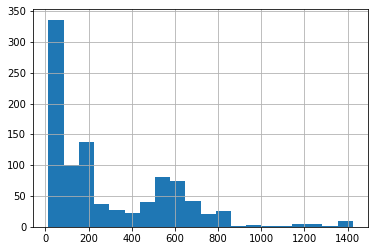

In [3]:
df['icu_patients'].hist(bins =20)

<Axes: >

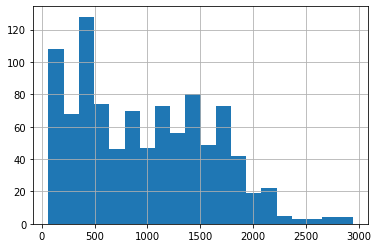

In [4]:
df['hosp_patients'].hist(bins =20)

<Axes: xlabel='date'>

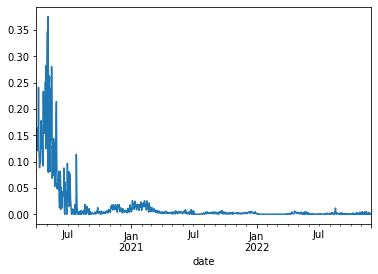

In [6]:
df['reproduction_rate'].plot()

<Axes: xlabel='date'>

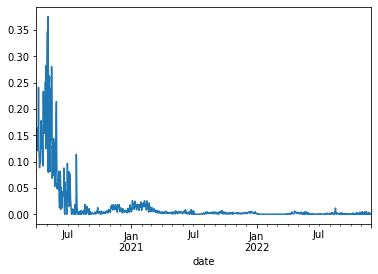

In [7]:
df['case_fatality'].plot()

In [10]:
df.tail()

,new_cases,new_deaths,icu_patients,hosp_patients,stringency_index,reproduction_rate,temp,humidity,precip,windspeed,case_fatality
date,,,,,,,,,,,
2022-11-26,2510.25,0.0,32.333333,583.0,11.11,0.000000,7.3,93.6,0.000,21.6,0.000000
2022-11-27,2573.50,0.0,32.666667,585.0,11.11,0.000000,6.7,91.8,1.120,24.6,0.000000
2022-11-28,2636.75,0.0,33.000000,587.0,11.11,0.000000,8.5,98.1,9.841,17.2,0.000000
2022-11-29,2700.00,2.0,32.000000,625.0,11.11,0.000741,7.1,96.7,0.190,7.6,0.000741
2022-11-30,2700.00,0.0,32.000000,609.0,11.11,0.000000,6.7,94.7,0.171,11.9,0.000000


In [11]:
def n_day_ahead(n, real, train_size):
    
    pred = []

    for i in range(new.shape[0]):
        pred.append(new[i][n-1])

    if n == h:
        y_test =  df[real][train_size+lag+h-1:]
    else:
        y_test =  df[real][train_size+lag+n-1:-h+n]
        
    r2_d1 = r2_score(y_test,pred)
    rmse_d1 =np.sqrt(mean_squared_error(y_test, pred))
    mae_d1=mean_absolute_error(y_test, pred) 
    mape_d1 =mean_absolute_percentage_error(y_test, pred)

    print(f"day{n}_R^2 = :", round(r2_d1,3))
    print(f"day{n}_RMSE = :",round(rmse_d1,3))
    print(f"day{n}_MAE = :",round(mae_d1,3))
    print(f"day{n}_MAPE = :",round(mape_d1,3))

    forecast= pd.DataFrame({real: y_test ,
                        f'{n}_day_ahead_forecast':pred})
    
    forecast[[real,f'{n}_day_ahead_forecast']].plot(figsize=(15,5))

Forecasting Hospital Admission

In [4]:
x_series = df[:].to_numpy()
y_series = df['hosp_patients'].to_numpy()
# Set the lag and the forecast horizon h
lag = 12
h = 4
X = []
Y = []
for t in range(len(y_series)- lag - h +1):
    x= x_series[t:t+lag]
    X.append(x)
    y=y_series[t+lag:t+lag+h]
    Y.append(y)

X = np.array(X).reshape(len(X),-1)
Y = np.array(Y).reshape(-1, h)

In [7]:
train_size = 400
Xtrain, Ytrain= X[:train_size], Y[:train_size]

# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'n_estimators': [50, 250,500,1000],
    'max_depth': [3, 5, 7]
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

time_split = TimeSeriesSplit(n_splits = 5)

# Perform grid search: grid_mse
grid_mse = GridSearchCV(param_grid = gbm_param_grid, estimator = gbm, scoring = "neg_mean_squared_error",
cv= time_split, verbose = 1)

# Fit grid_mse to the data
grid_mse.fit(Xtrain, Ytrain)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'colsample_bytree': 0.7, 'max_depth': 3, 'n_estimators': 50}
Lowest RMSE found:  295.9512221738003


In [15]:
def walk_forward(X, Y, train_size):

    predictions=[]

    for i in range(X.shape[0]-train_size):
        Xtrain, Ytrain= X[i : i+train_size], Y[i : i+train_size]
        Xtest, Ytest = X[i+train_size: i+train_size+1], Y[i+train_size: i+train_size+1]
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, max_depth=3, colsample_bytree = 0.7, random_state= 77)
        model.fit(Xtrain, Ytrain, verbose=0) 
        pred =model.predict(Xtest)
        predictions.append(pred)

    return predictions


In [16]:
train_size = 400
pred = walk_forward(X, Y, train_size)

day1_R^2 = : 0.989
day1_RMSE = : 53.475
day1_MAE = : 39.114
day1_MAPE = : 0.063
day2_R^2 = : 0.98
day2_RMSE = : 71.942
day2_MAE = : 52.326
day2_MAPE = : 0.083
day3_R^2 = : 0.969
day3_RMSE = : 89.218
day3_MAE = : 64.124
day3_MAPE = : 0.113
day4_R^2 = : 0.964
day4_RMSE = : 95.703
day4_MAE = : 66.931
day4_MAPE = : 0.117


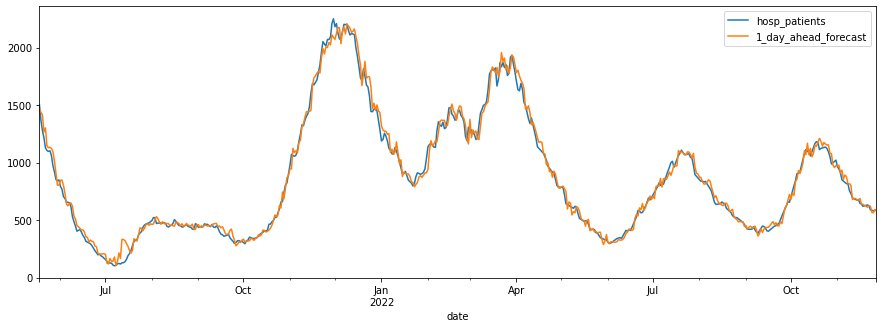

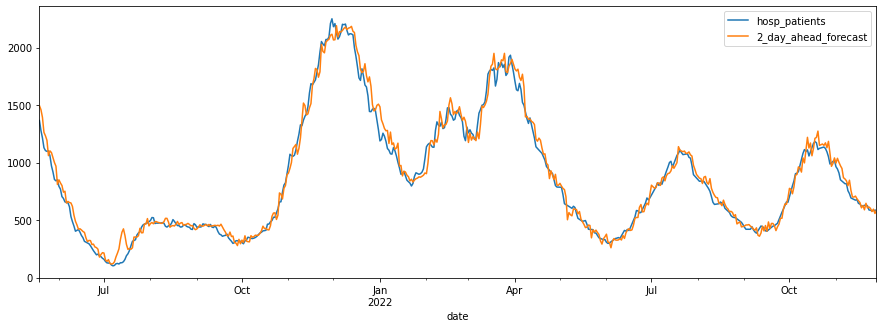

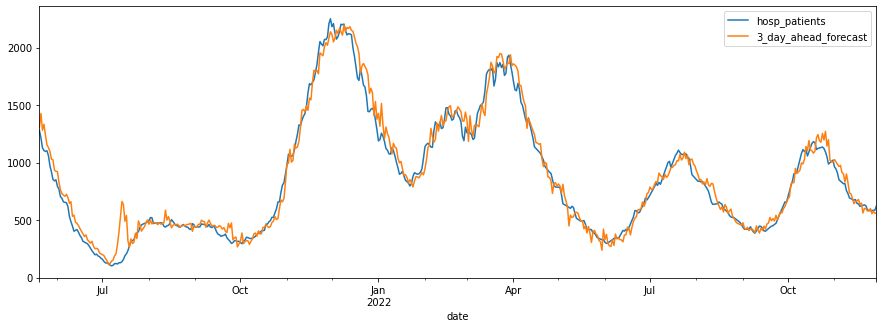

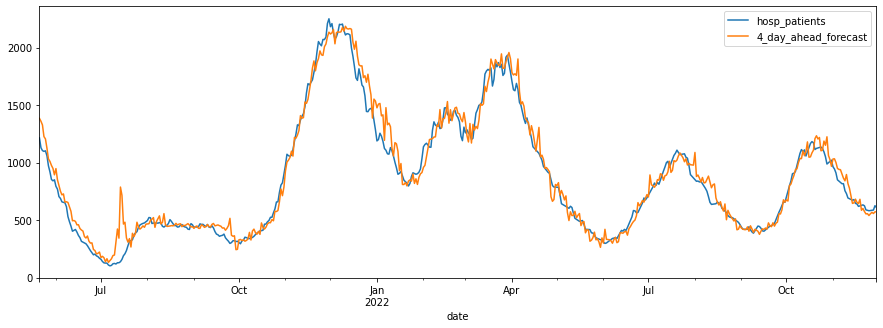

In [17]:
new = np.array(pred).reshape(-1,h)
for i in range(1,h+1):
    n_day_ahead(i, real='hosp_patients', train_size= train_size)

Forecasting ICU admission

In [32]:
x_series = df[:].to_numpy()
y_series = df['icu_patients'].to_numpy()
# Set the lag and the forecast horizon h
lag = 12
h = 4
X = []
Y = []
for t in range(len(y_series)- lag - h +1):
    x= x_series[t:t+lag]
    X.append(x)
    y=y_series[t+lag:t+lag+h]
    Y.append(y)

X = np.array(X).reshape(len(X),-1)
Y = np.array(Y).reshape(-1, h)


In [42]:
train_size = 400
Xtrain, Ytrain= X[:train_size], Y[:train_size]

# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'n_estimators': [50, 250,500,1000],
    'max_depth': [3, 5, 7]
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

time_split = TimeSeriesSplit(n_splits = 5)

# Perform grid search: grid_mse
grid_mse = GridSearchCV(param_grid = gbm_param_grid, estimator = gbm, scoring = "neg_mean_squared_error", cv= time_split, verbose = 1)

# Fit grid_mse to the data
grid_mse.fit(Xtrain, Ytrain)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest MSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'colsample_bytree': 0.3, 'max_depth': 3, 'n_estimators': 50}
Lowest MSE found:  92.58068566211423


In [43]:
def walk_forward(X, Y, train_size):

    predictions=[]

    for i in range(X.shape[0]-train_size):
        Xtrain, Ytrain= X[i : i+train_size], Y[i : i+train_size]
        Xtest, Ytest = X[i+train_size: i+train_size+1], Y[i+train_size: i+train_size+1]
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, max_depth=3, colsample_bytree = 0.3, random_state = 321)
        model.fit(Xtrain, Ytrain, verbose=0) 
        pred =model.predict(Xtest)
        predictions.append(pred)

    return predictions


In [44]:
train_size = 400
pred = walk_forward(X, Y, train_size)

In [45]:
new = np.array(pred).reshape(-1,4)

day1_R^2 = : 0.989
day1_RMSE = : 17.075
day1_MAE = : 10.784
day1_MAPE = : 0.078
day2_R^2 = : 0.986
day2_RMSE = : 19.191
day2_MAE = : 11.169
day2_MAPE = : 0.082
day3_R^2 = : 0.982
day3_RMSE = : 22.21
day3_MAE = : 12.626
day3_MAPE = : 0.088
day4_R^2 = : 0.983
day4_RMSE = : 20.948
day4_MAE = : 12.565
day4_MAPE = : 0.091


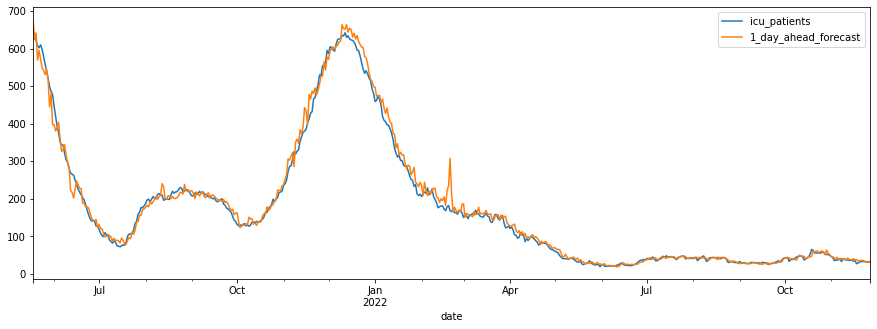

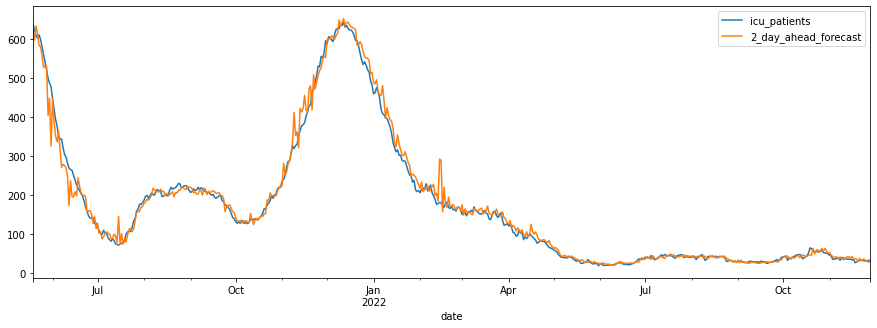

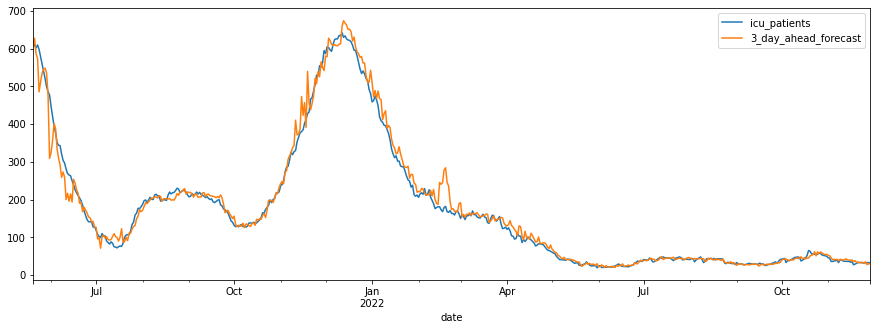

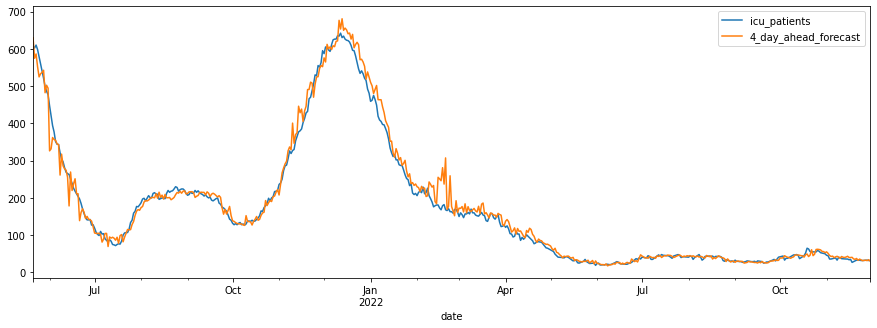

In [46]:
for i in range(1,5):
    n_day_ahead(i, real='icu_patients', train_size= train_size)

In [18]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.7.1
numpy               1.22.2
pandas              1.4.1
scipy               1.10.1
session_info        1.0.0
sklearn             1.2.2
xgboost             1.7.5
-----
IPython             8.0.1
jupyter_client      7.1.2
jupyter_core        4.9.1
jupyterlab          3.2.9
notebook            6.4.8
-----
Python 3.10.2 (v3.10.2:a58ebcc701, Jan 13 2022, 14:50:16) [Clang 13.0.0 (clang-1300.0.29.30)]
macOS-12.3.1-x86_64-i386-64bit
-----
Session information updated at 2023-05-30 18:24
